In [2]:
import os
import glob
import cv2 
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

In [3]:
def readImage(location):
    image = nib.load(location)
    return np.array(image.get_fdata())[:,:,:,0]/np.array(image.get_fdata())[:,:,:,0].max()

In [4]:
def getSegments(subject):
    ret,thresh_low = cv2.threshold(subject,0.20,255,cv2.THRESH_BINARY)
    ret,thresh_med = cv2.threshold(subject,0.40,255,cv2.THRESH_BINARY)
    ret,thresh_high = cv2.threshold(subject,0.60,255,cv2.THRESH_BINARY)
    
    return np.append(np.append(
    cv2.bitwise_and(thresh_low[:,:,:],subject[:,:,:]).reshape(128,128,63,1),
    cv2.bitwise_and(thresh_med[:,:,:],subject[:,:,:]).reshape(128,128,63,1),
    axis=-1), cv2.bitwise_and(thresh_high[:,:,:],subject[:,:,:]).reshape(128,128,63,1),axis=-1)

In [4]:
#Alzhimers Dataset
ad = []
for x in tqdm(glob.glob('./Dataset/AD/*/*/*.nii')):
    ad.append(getSegments(readImage(x)))
    
ad = np.array(ad)

#Normal Dataset
cn = []
for x in tqdm(glob.glob('./Dataset/CN/*/*/*.nii')):
    cn.append(getSegments(readImage(x)))
    
cn = np.array(cn)


#MIC Dataset
mic = []
for x in tqdm(glob.glob('./Dataset/MIC/*/*/*.nii')):
    mic.append(getSegments(readImage(x)))
    
mic = np.array(mic)

gc.collect()

X = np.append(ad,cn,axis=0)
gc.collect()
X = np.append(X,mic,axis=0)
gc.collect()
Y = np.array([0]*ad.shape[0] + [1]*cn.shape[0] + [2]*mic.shape[0])
gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████| 432/432 [00:27<00:00, 15.74it/s]


0

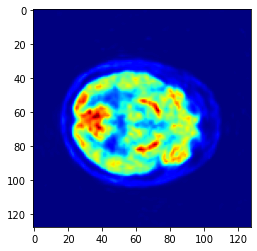

In [5]:
plt.imshow(readImage(glob.glob('./Dataset/AD/*/*/*.nii')[155])[:,:,30],cmap='jet')
plt.show()

In [6]:
X.shape

(1002, 128, 128, 63, 3)

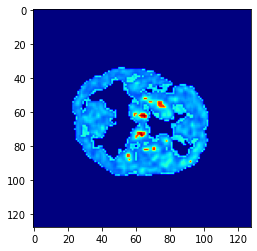

In [7]:
plt.imshow(X[100,:,:,32,0],cmap='jet')
plt.show()

In [8]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [9]:
Y= ohe.fit_transform(Y.reshape(-1,1))

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25)

In [11]:
y_train = y_train.toarray()
y_test = y_test.toarray()

## Making the Model

In [5]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv3D,Dense,MaxPool3D,ReLU,Input,concatenate,Flatten,BatchNormalization, Dropout, GlobalAveragePooling3D

In [51]:
#For low intensity segments
input_layer = Input(shape=(128,128,63,3),name='input')
model = Conv3D(filters=128*3, kernel_size=3, strides=2,padding='same', activation=None, groups = 3, name="GroupConv1")(input_layer)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

model = Conv3D(filters=128*3, kernel_size=3, strides=1,padding='same', activation=None , groups = 3, name="GroupConv2")(model)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

model = Conv3D(filters=256*3, kernel_size=3, strides=2,padding='same', activation=None, groups = 3, name="GroupConv3")(model)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

model = Conv3D(filters=256*3, kernel_size=3, strides=1,padding='same', activation=None , groups = 3, name="GroupConv4")(model)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

#Classification Network
classifier = Conv3D(filters=1024, kernel_size=3, strides=2,padding='same', activation=None)(model)
classifier = BatchNormalization(center=True, scale=True)(classifier)
classifier = ReLU()(classifier)
classifier = Dropout(0.5)(classifier)

flatten = GlobalAveragePooling3D()(classifier)

dense = Dense(256, activation='relu')(flatten)
output = Dense(3, activation='softmax')(dense)

In [52]:
model = Model(input_layer,output)

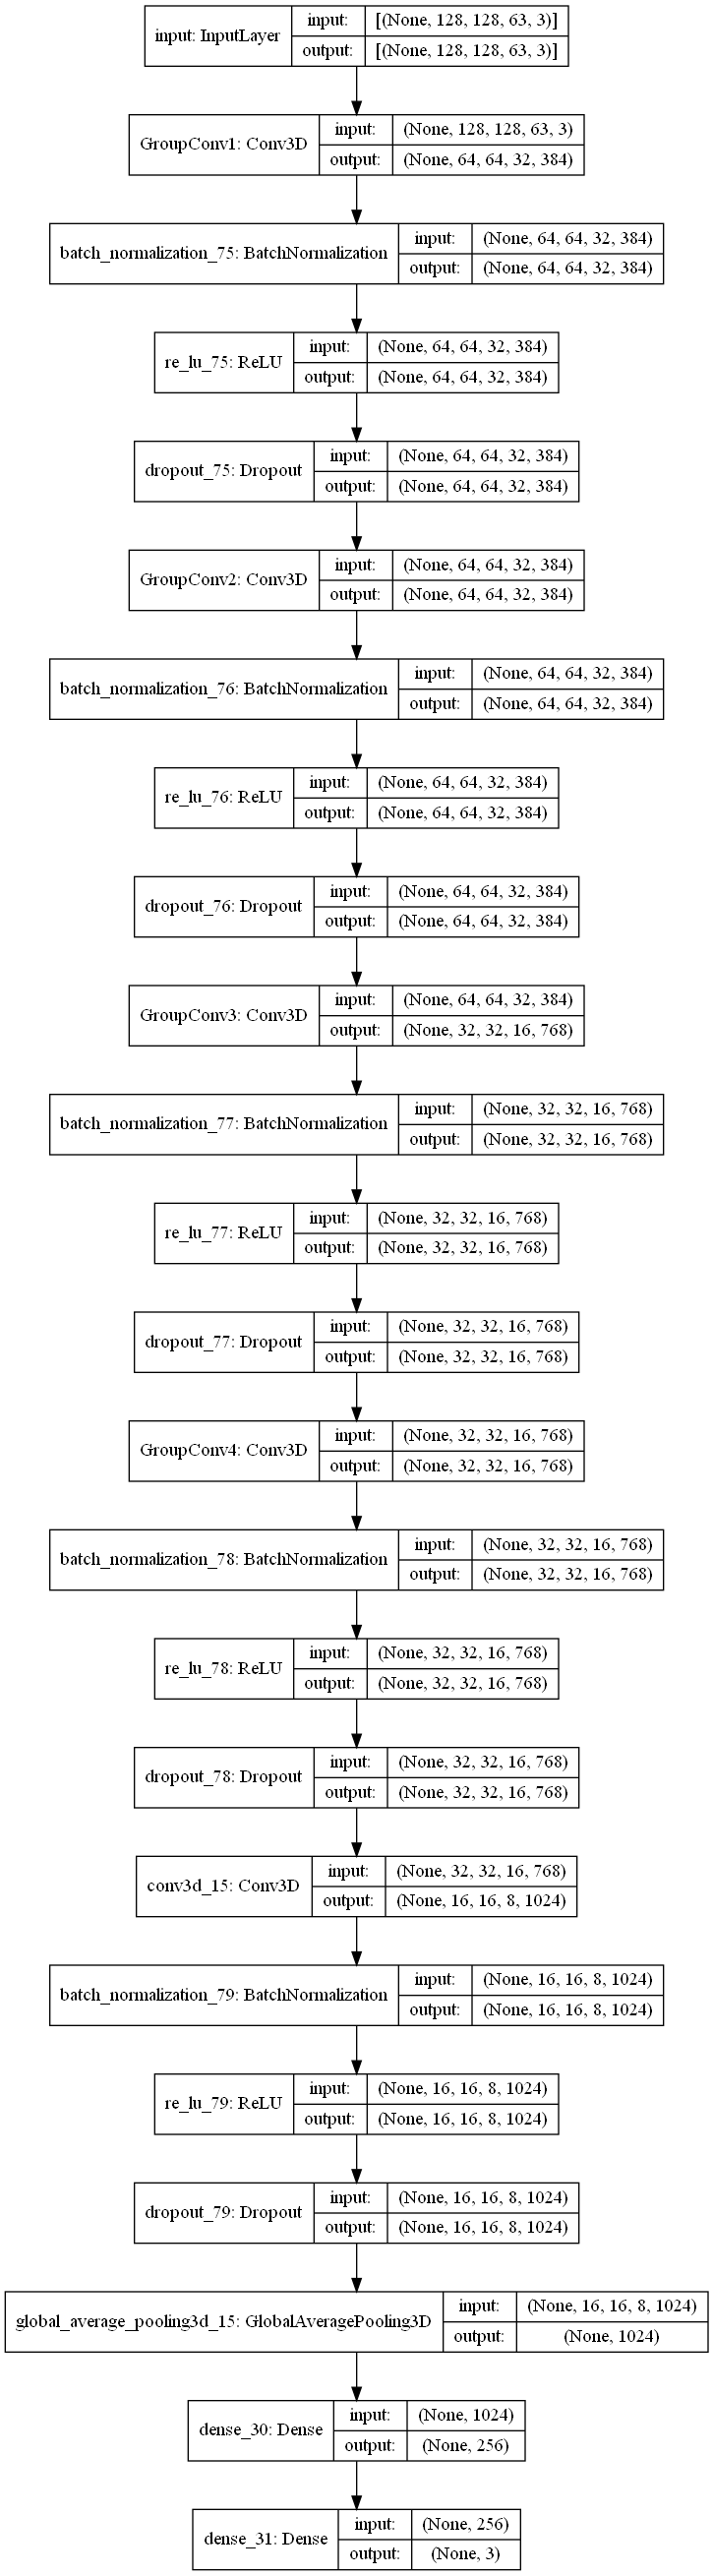

In [53]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [11]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

training_x = {'input_li':X_li_train,'input_mi':X_mi_train,'input_hi':X_hi_train}
testing_x = {'input_li':X_li_test,'input_mi':X_mi_test,'input_hi':X_hi_test}

In [17]:
X_li_train = X_train[:,0,:,:]
X_mi_train = X_train[:,1,:,:]
X_hi_train = X_train[:,2,:,:]

X_li_test = X_test[:,0,:,:]
X_mi_test = X_test[:,1,:,:]
X_hi_test = X_test[:,2,:,:]


#training_x = {'input_li':X_li_train,'input_mi':X_mi_train,'input_hi':X_hi_train}


In [17]:
train_set = tf.data.Dataset.from_tensor_slices(({'input_li':X_li_train,'input_mi':X_mi_train,'input_hi':X_hi_train}, y_train))
train_set = train_set.batch(2, drop_remainder=True)

test_set = tf.data.Dataset.from_tensor_slices(({'input_li':X_li_test,'input_mi':X_mi_test,'input_hi':X_hi_test}, y_test))
test_set = test_set.batch(2, drop_remainder=True)

MemoryError: Unable to allocate 5.78 GiB for an array with shape (751, 128, 128, 63) and data type float64

In [18]:
model.fit(x=X_train,
          y=y_train,
          batch_size=5,
          epochs=1)

MemoryError: Unable to allocate 8.66 GiB for an array with shape (751, 128, 128, 63, 3) and data type float32